In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
from scipy.spatial import ConvexHull

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, extract_transect_center


In [2]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150,150,:]


In [3]:
from utils import moca_grid, dopioe_grid, espra, espra_Rc, moca, dopioe

NIC, NJC = 45, 45


In [4]:
df_MOCA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Rc', r'$\psi_0$'])
for eddy in the_frontier_eddies:
# for eddy in [the_frontier_eddies[0]]:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
        X_roms, Y_roms = X_roms.T, Y_roms.T

        xc_pre, yc_pre = 0, 0
        # nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        nic, njc = NIC, NJC
        r_roms = 15
        for k in range(10):

            u_roms, v_roms = U_roms[:, :, k], V_roms[:,:, k]
            dic = extract_transect_center(u_roms, v_roms, X_roms, Y_roms, x_roms[nic], y_roms[njc], r=r_roms)

            x1 = dic['x1']
            y1 = dic['y1']
            u1 = dic['u1']
            v1 = dic['v1']

            l = x1 - x1.min()
            VT, VN = u1, v1
            l0, r0, w, Q, Rc_opt, psi0_opt = moca(l, VT, VN)
            xc, yc = x1.min() + l0, y1[0] + r0
            
            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_MOCA.loc[len(df_MOCA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc,
                                                 'z': k, 'Depth': z_r[k], 'w': w, 'Rc': Rc_opt, r'$\psi_0$': psi0_opt}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x_roms - xc).argmin() #FIXED FOR PLOTTING PURPOSES!
                    njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break
                

In [5]:
df_DOPIOE = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q', 'Rc', r'$\psi_0$'])
for eddy in the_frontier_eddies:
# for eddy in [the_frontier_eddies[0]]:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
        X_roms, Y_roms = X_roms.T, Y_roms.T

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        nic, njc = NIC, NJC
        r_roms = 15
        for k in range(10): #22

            u_roms, v_roms = U_roms[:, :, k], V_roms[:,:, k]
            dic = extract_transect_center(u_roms, v_roms, X_roms, Y_roms, x_roms[nic], y_roms[njc], r=r_roms)

            x1 = dic['x1']
            y1 = dic['y1']
            u1 = dic['u1']
            v1 = dic['v1']
            x2 = dic['x2']
            y2 = dic['y2']
            u2 = dic['u2']
            v2 = dic['v2']

            xc, yc, w, Q, Rc_opt, psi0_opt = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_DOPIOE.loc[len(df_DOPIOE)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc,
                                                     'z': k, 'Depth': z_r[k], 'w': w, 'Q': Q,
                                                    'Rc': Rc_opt, r'$\psi_0$': psi0_opt}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x_roms - xc).argmin()
                    njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break
                

In [6]:
df_ESPRA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q', 'Rc', r'$\psi_0$'])
for eddy in the_frontier_eddies:
# for eddy in [the_frontier_eddies[0]]:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
        X_roms, Y_roms = X_roms.T, Y_roms.T

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        nic, njc = NIC, NJC
        r_roms = 15
        for k in range(10):

            u_roms, v_roms = U_roms[:, :, k], V_roms[:,:, k]

            mask = (np.hypot(X_roms - x_roms[nic], Y_roms - y_roms[njc]) < r_roms).T
            xi, yi = X_roms[mask], Y_roms[mask]
            ui, vi = u_roms[mask], v_roms[mask]

            xc, yc, w, Q, Rc_opt, psi0_opt = espra(xi, yi, ui, vi)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_ESPRA.loc[len(df_ESPRA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc,
                                                   'z': k, 'Depth': z_r[k], 'w': w, 'Q': Q,
                                                  'Rc': Rc_opt, r'$\psi_0$': psi0_opt}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x_roms - xc).argmin()
                    njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break
                

In [7]:
df_MOCA_PAPER2 = pd.DataFrame({
    'Eddy': [the_frontier_eddies[0]]*3 + [the_frontier_eddies[1]]*3 + [the_frontier_eddies[2]]*3 + [the_frontier_eddies[3]]*3,
    'Day': [0, 23, 28,   0, 7, 25,  0, 19, 24,  1, 5, 14],
    'z': [0, 6, 3,       0, 0, 9,   0, 6, 3,    3, 3,  6],
    'Method' : ['MOCA'] * 12
    })

df_DOPIOE_PAPER2 = pd.DataFrame({
    'Eddy': [the_frontier_eddies[0]]*3 + [the_frontier_eddies[1]]*3 + [the_frontier_eddies[2]]*3 + [the_frontier_eddies[3]]*3,
    'Day': [0, 23, 28,   0, 7, 25,  0, 19, 24,  1, 5, 14],
    'z': [0, 6, 3,       0, 0, 9,   0, 6, 3,    3, 3,  6],
    'Method' : ['DOPIOE'] * 12
    })

df_ESPRA_PAPER2 = pd.DataFrame({
    'Eddy': [the_frontier_eddies[0]]*3 + [the_frontier_eddies[1]]*3 + [the_frontier_eddies[2]]*3 + [the_frontier_eddies[3]]*3,
    'Day': [0, 23, 28,   0, 7, 25,  0, 19, 24,  1, 5, 14],
    'z': [0, 6, 3,       0, 0, 9,   0, 6, 3,    3, 3,  6],
    'Method' : ['ESPRA'] * 12
    })


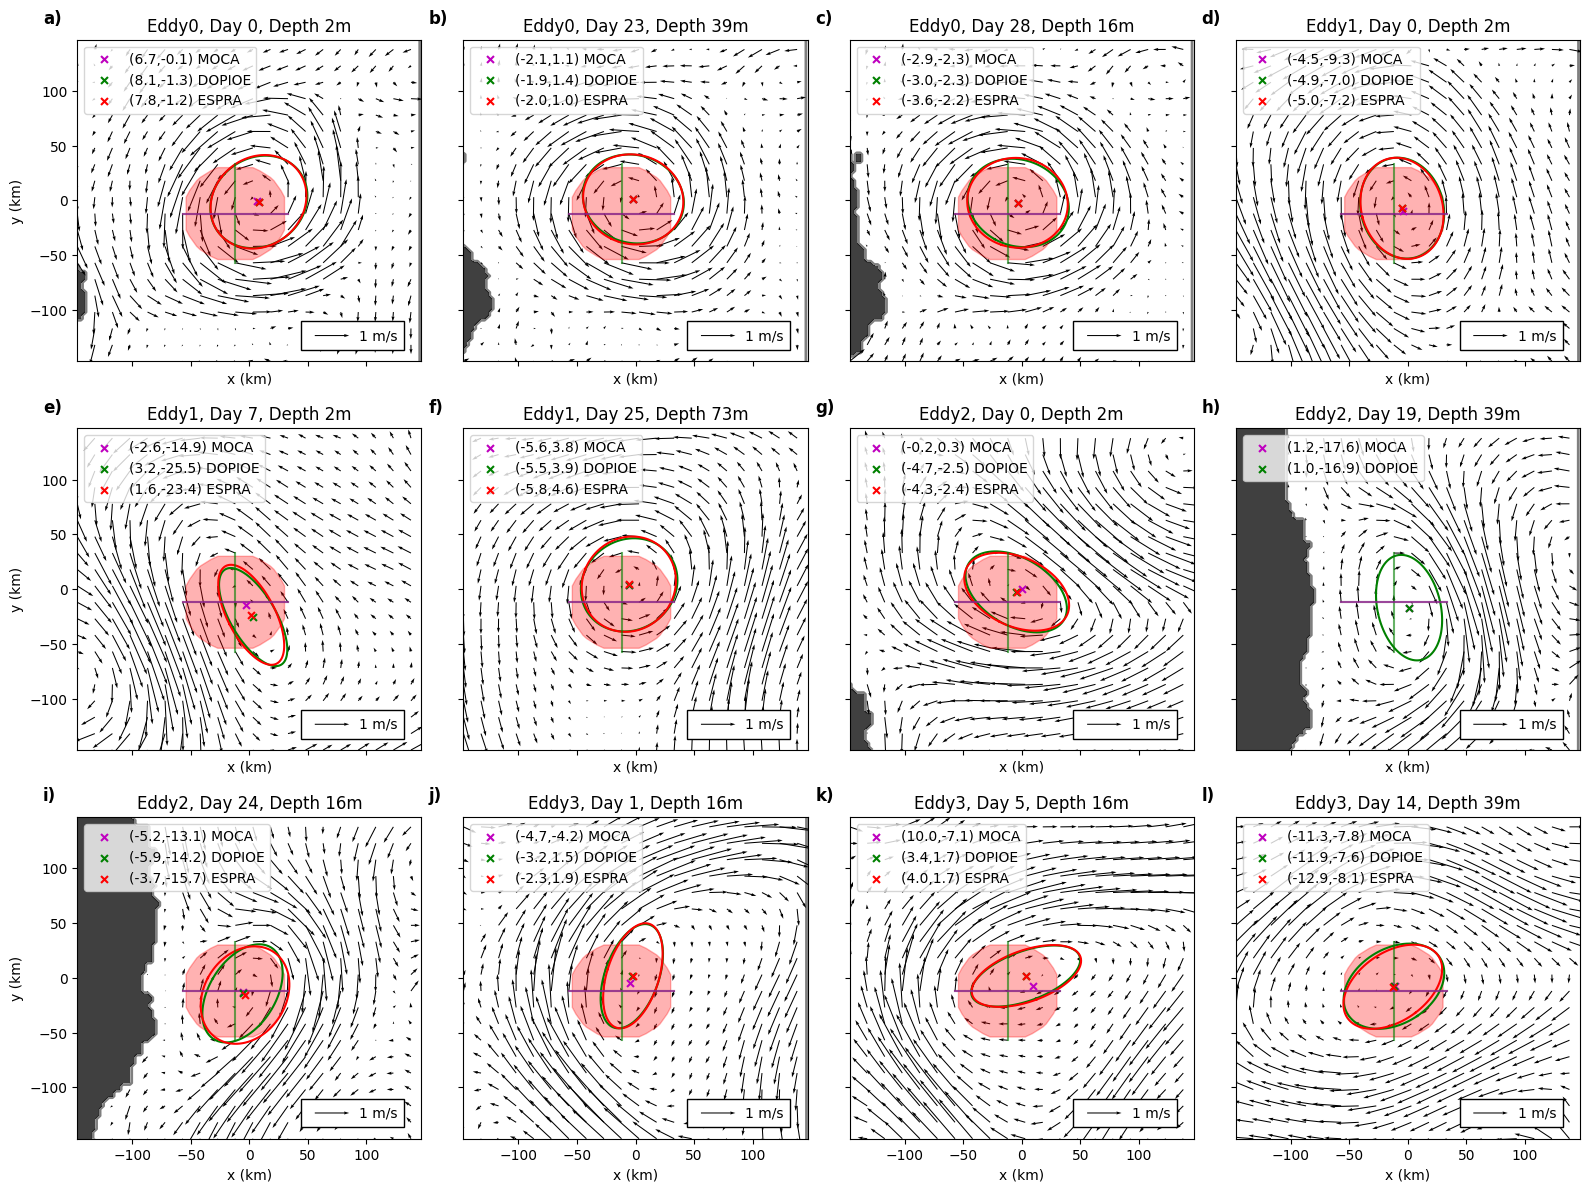

In [8]:
def int_to_excel(n):
    # Convert 0-indexed integer n to an Excel-style column label in lowercase
    n += 1  # Convert to 1-indexed
    result = ""
    while n:
        n, remainder = divmod(n - 1, 26)
        result = chr(97 + remainder) + result  # 97 is ASCII for 'a'
    return result

dfs = [df_MOCA_PAPER2, df_DOPIOE_PAPER2, df_ESPRA_PAPER2]

rows, cols = 3, 4

scale = 10
s = 25

fig, axs = plt.subplots(rows, cols, figsize=(16, 12), sharey=True, sharex=True)


for k in range(len(df_ESPRA_PAPER2)):

    for d, df in enumerate(dfs):
    
        ax = axs[k // cols, k % cols]
    
        df_rel = df.iloc[k]
        eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

        if d == 0:
            x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
            X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
            u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
            v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
            spacing = 5
            quiv = ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T, scale=scale)
        
        if df['Method'].iloc[0] == 'MOCA':

            df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

            if len(df_rel) > 0:
        
                xc, yc, nic, njc, depth, w = df_rel['xc'].iloc[0], df_rel['yc'].iloc[0], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']
    
                nic, njc = NIC, NJC
            
                # ax.plot(X_roms[nic, njc], Y_roms[nic, njc], marker='.', color='b')
                ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'm', zorder=4, alpha=0.6)
                
                ax.scatter(xc, yc, marker='x', s=s, color='m', zorder=4, label=f'({xc:.1f},{yc:.1f}) MOCA')
            
        if df['Method'].iloc[0] == 'DOPIOE':

            df_rel = df_DOPIOE[(df_DOPIOE['Eddy']==eddy) & (df_DOPIOE['Day']==t) & (df_DOPIOE['z']==depth_lvl)]

            if len(df_rel) > 0:
                xc, yc, nic, njc, depth, w, Q = df_rel['xc'].iloc[0], df_rel['yc'].iloc[0], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']
    
                nic, njc = NIC, NJC
                
                ax.plot([X_roms[nic-r_roms, njc], X_roms[nic+r_roms, njc]], [Y_roms[nic-r_roms, njc], Y_roms[nic+r_roms, njc]], 'g', zorder=3, alpha=0.6)
                ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'g', zorder=3, alpha=0.6)
    
                if not len(df_rel) == 0:
                    ax.scatter(xc, yc, marker='x', s=s, color='g', zorder=4, label=f'({xc:.1f},{yc:.1f}) DOPIOE')
    
                    Q = Q.iloc[0]
                    x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
                    ax.plot(x_ellipse, y_ellipse, color='g')

        if df['Method'].iloc[0] == 'ESPRA':

            df_rel = df_ESPRA[(df_ESPRA['Eddy']==eddy) & (df_ESPRA['Day']==t) & (df_ESPRA['z']==depth_lvl)]
            if len(df_rel) > 0:
                xc, yc, nic, njc, depth, w, Q = df_rel['xc'].iloc[0], df_rel['yc'].iloc[0], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w'], df_rel['Q']
                
                nic, njc = NIC, NJC
    
                mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
                points = np.column_stack((X_roms[mask], Y_roms[mask]))
                
                if len(points) > 2:  # Convex hull requires at least 3 points
                    hull = ConvexHull(points)
                    ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='r', alpha=0.3)
    
                if not len(df_rel) == 0:
    
                    ax.scatter(xc, yc, marker='x', s=s, color='r', zorder=4, label=f'({xc:.1f},{yc:.1f}) ESPRA')
    
                    Q = Q.iloc[0]
                    x_ellipse, y_ellipse = plot_ellipse(Q, center=(xc, yc), scale=50)
                    ax.plot(x_ellipse, y_ellipse, color='r')

        if d == 0:
            if np.any(np.isnan(u_roms)):
                nan_mask = np.isnan(u_roms)
                mask = np.where(~np.isnan(u_roms), np.nan, 0)
                ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
                ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)
        
            ax.set_title(f'Eddy{the_frontier_eddies.index(eddy)}, Day {t}, Depth {-round(z_r[depth_lvl])}m', fontsize=12)
        
        if d + k // cols == rows - 1:
            ax.set_xlabel('x (km)')
        if k % cols == 0:
            ax.set_ylabel('y (km)')

        if d == 0:
            ax.text(-0.1, 1.05, int_to_excel(k)+')', transform=ax.transAxes, fontsize=12, fontweight='bold')
 
    
        # ax.axis('equal')
        if d == 0:
            magnitude = 1
            x_pos, y_pos = 0.8, 0.08  
            box_width = 0.3 # Adjust width as needed
            box_height = 0.09  # Adjust height as needed
            rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                                   box_width, box_height, transform=ax.transAxes,
                                   facecolor='white', edgecolor='black')
            ax.add_patch(rect)
            ax.quiverkey(quiv, X=x_pos-.01, Y=y_pos, U=magnitude,
                         label=f'{magnitude} m/s', labelpos='E')

        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()



In [9]:
df_DOPIOE

,Eddy,Day,xc,yc,nic,njc,z,Depth,w,Q,Rc,$\psi_0$
0,Eddy790,0,8.088215,-1.325934,45,45,0,-1.783320,0.033716,"[[0.008591021392378039, -0.001133854169546207]...",31.543853,1035.279543
1,Eddy790,0,6.439169,0.326101,52,49,1,-5.879627,0.036815,"[[0.009933412388184544, -0.0021511477944719686...",6.638395,43.425534
2,Eddy790,0,5.914400,0.730255,51,49,2,-10.725783,0.036546,"[[0.00981334485833417, -0.0020827155038010167]...",6.010620,35.461093
3,Eddy790,0,5.321170,0.912902,51,49,3,-16.383097,0.036308,"[[0.009742223318378557, -0.002073134517368651]...",5.265199,27.163917
4,Eddy790,0,4.664118,0.877039,51,49,4,-22.925581,0.036048,"[[0.009641553129921699, -0.002064075791667794]...",5.209689,26.630213
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,Eddy775,29,4.149528,-2.287764,50,48,5,-30.444118,-0.016272,"[[-0.0025289926647502152, -0.00170744185461779...",3.601539,13.255155
1186,Eddy775,29,4.277421,-2.524234,50,48,6,-39.052712,-0.016267,"[[-0.00253909292831989, -0.0017169277198763931...",3.934977,15.797669
1187,Eddy775,29,4.493498,-2.786776,50,48,7,-48.897638,-0.016306,"[[-0.00255839714212292, -0.0018805178265318202...",5.212625,27.372664
1188,Eddy775,29,5.122397,-3.093422,50,48,8,-60.170639,-0.016328,"[[-0.002556946705440184, -0.001863931277737630...",6.303426,39.996801


In [10]:
df_DOPIOE['Eddy'].unique()

array(['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775'], dtype=object)

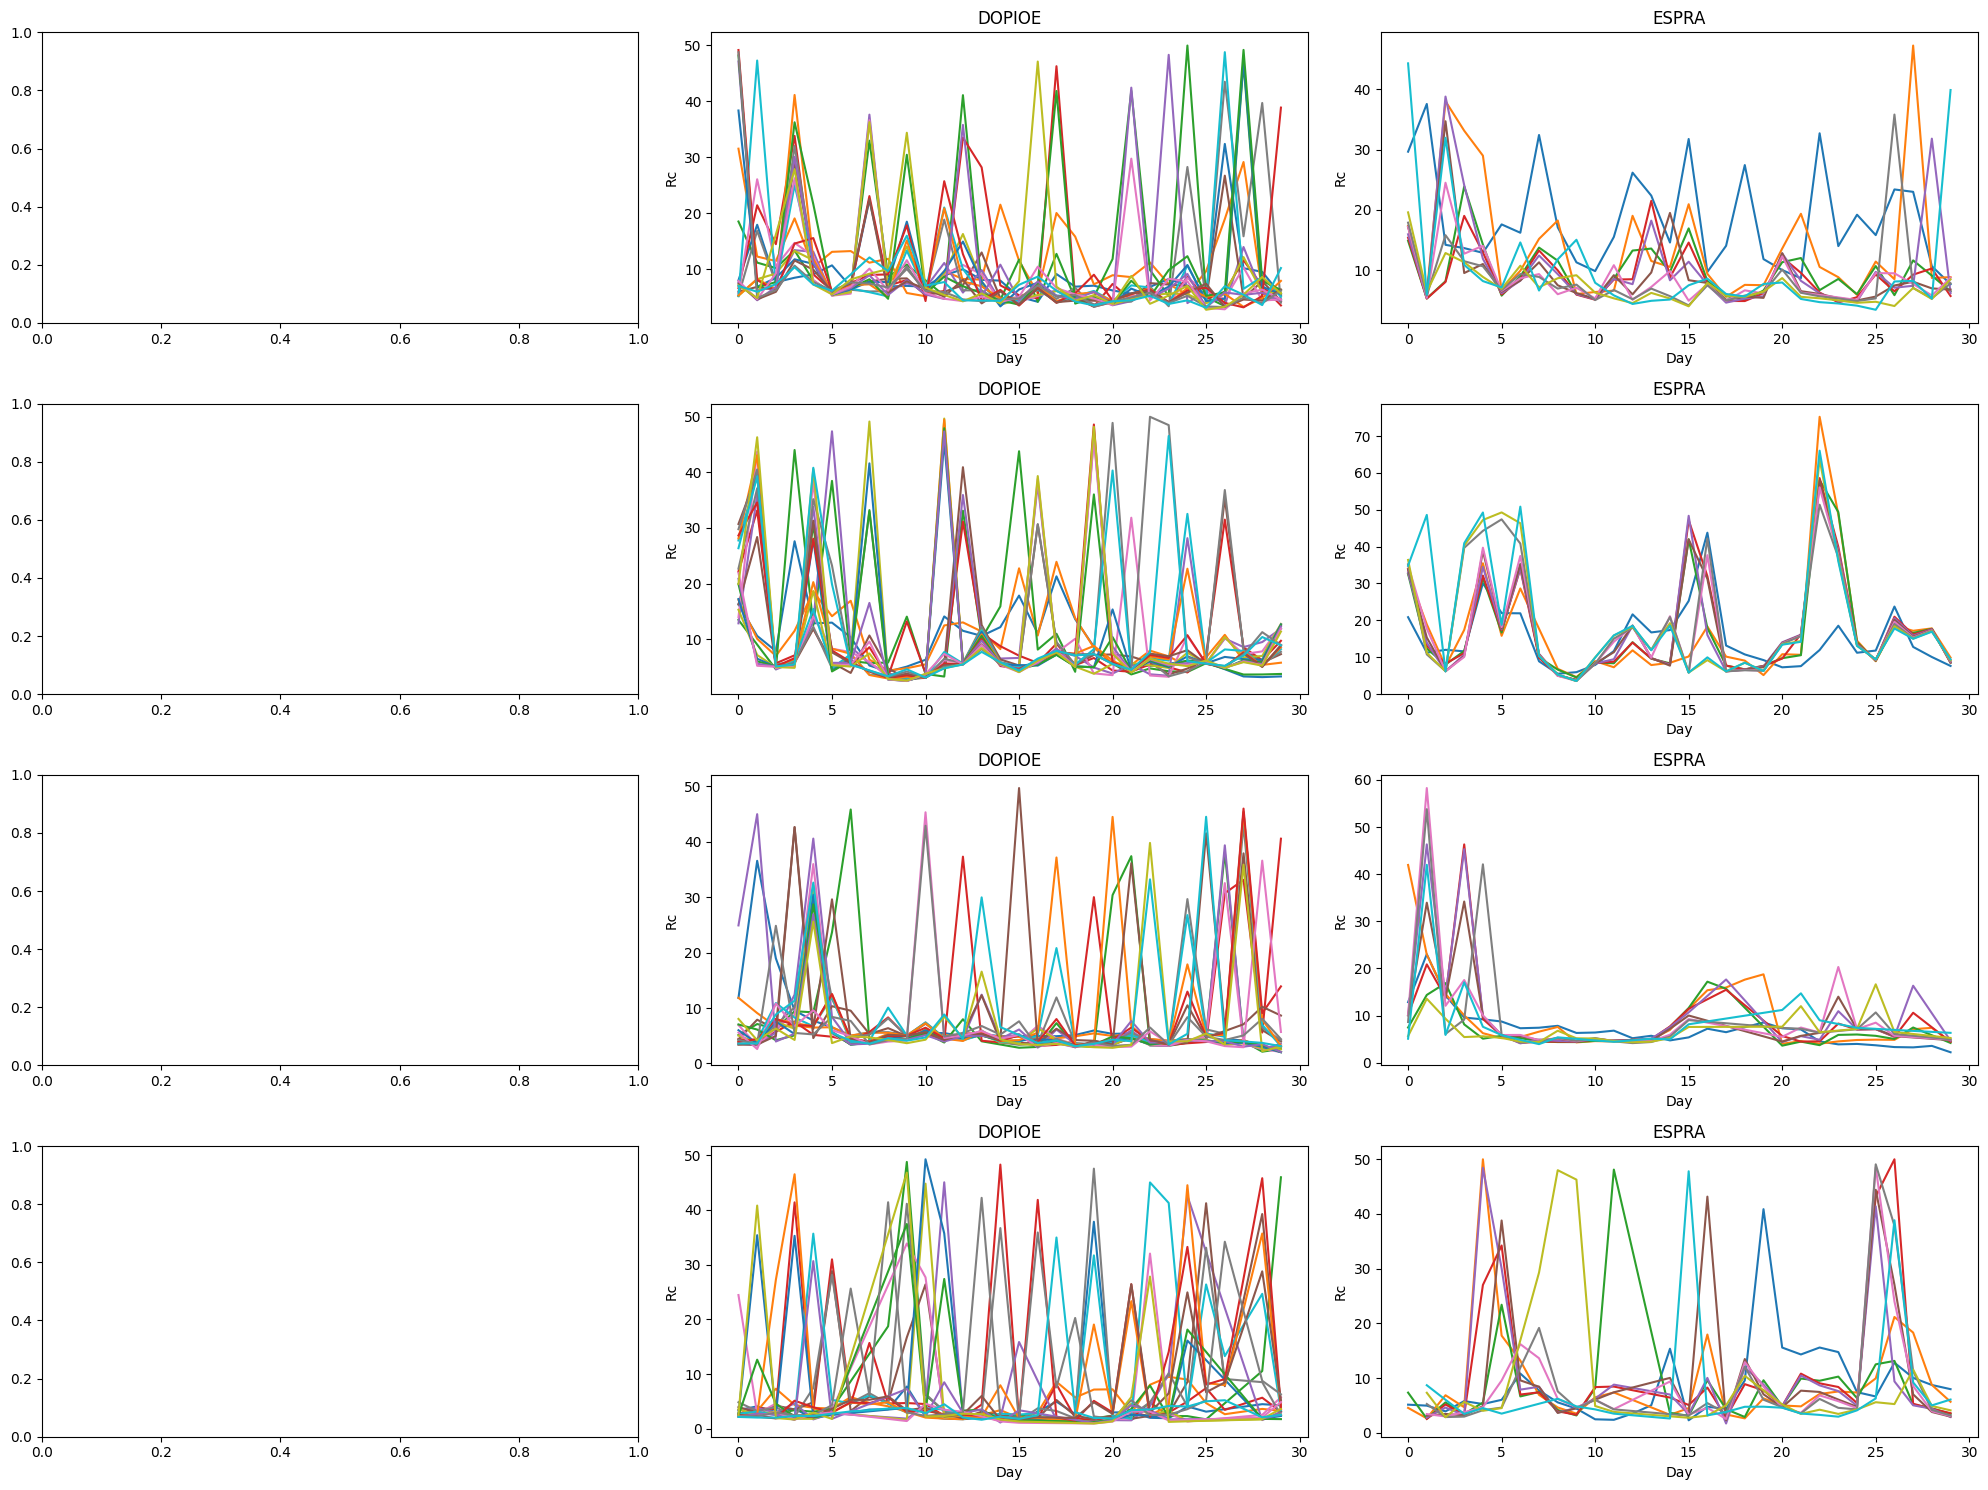

In [11]:
fig, axs = plt.subplots(4, 3, figsize=(20,15))
for e, eddy in enumerate(the_frontier_eddies):
    for k in range(len(z_r)):
    # for k in range(10):
        df = df_MOCA[(df_MOCA['Eddy']==eddy)&(df_MOCA['Depth']==z_r[k])]
        axs[e,1].plot(df['Day'], df['Rc'], label=k)
        # axs[0].legend()
        axs[e,1].set_title('MOCA')
        axs[e,1].set_xlabel('Day')
        axs[e,1].set_ylabel('Rc')
        df = df_DOPIOE[(df_DOPIOE['Eddy']==eddy)&(df_DOPIOE['Depth']==z_r[k])]
        axs[e,1].plot(df['Day'], df['Rc'], label=k)
        # axs[0].legend()
        axs[e,1].set_title('DOPIOE')
        axs[e,1].set_xlabel('Day')
        axs[e,1].set_ylabel('Rc')
        df = df_ESPRA[(df_ESPRA['Eddy']==eddy)&(df_ESPRA['Depth']==z_r[k])]
        axs[e,2].plot(df['Day'], df['Rc'], label=k)
        # axs[1].legend()
        axs[e,2].set_title('ESPRA')
        axs[e,2].set_xlabel('Day')
        axs[e,2].set_ylabel('Rc')

plt.tight_layout()
plt.show()


In [12]:
# df = df_ESPRA[(df_ESPRA['Eddy']==eddy)&(df_ESPRA['Day']==2)]

eddy = the_frontier_eddies[3]
df = df_DOPIOE[(df_DOPIOE['Eddy']==eddy)&(df_DOPIOE['Day']==15)]
df

,Eddy,Day,xc,yc,nic,njc,z,Depth,w,Q,Rc,$\psi_0$
1050,Eddy775,15,-13.021214,-8.816019,45,45,0,-1.783320,-0.011804,"[[-0.002211525907172307, 0.0014503687332078619...",2.003059,-3.930752
1051,Eddy775,15,-15.904825,-11.959057,45,46,1,-5.879627,-0.012300,"[[-0.0021878996123504426, 0.001260850281681559...",1.659735,2.891040
1052,Eddy775,15,-16.960258,-13.385540,44,45,2,-10.725783,-0.012275,"[[-0.002184290920309907, 0.0013743547010837778...",2.049468,4.327898
1053,Eddy775,15,-17.539759,-14.344730,43,45,3,-16.383097,-0.012277,"[[-0.0021875361624697294, 0.001402827326348107...",1.466763,2.229282
1054,Eddy775,15,-17.517432,-14.884209,43,44,4,-22.925581,-0.012600,"[[-0.0022529962878935755, 0.001614678307079710...",2.600960,6.784951
1055,Eddy775,15,-17.338309,-15.246666,43,44,5,-30.444118,-0.012725,"[[-0.0022944989411562535, 0.001622482295968675...",1.914813,3.739766
1056,Eddy775,15,-16.551331,-15.239820,43,44,6,-39.052712,-0.012799,"[[-0.002365531521314041, 0.0016098109989049246...",1.761496,3.187737
1057,Eddy775,15,-14.502820,-14.423450,43,44,7,-48.897638,-0.012768,"[[-0.002362336962583659, 0.0016897293197467983...",1.753223,3.141009
1058,Eddy775,15,-10.429709,-11.126666,44,44,8,-60.170639,-0.012502,"[[-0.0024663191173619784, 0.001626376439243818...",2.051819,-3.981265
1059,Eddy775,15,-9.181036,-10.613777,46,45,9,-73.127842,-0.011976,"[[-0.0022951216900766076, 0.001426848939645551...",1.805819,-3.118060


In [13]:
from utils import gaussian_vel_reconstruction

dic = {}
for k in df['z']:
    dic[f'z{k}'] = {}
    data = df[df['z']==k]
    Q = data.iloc[0].Q
    q11e = Q[0,0]
    q12e = Q[0,1]
    q22e = Q[1,1]
    x0e = data.iloc[0].xc
    y0e = data.iloc[0].yc
    Depthe = -data.iloc[0].Depth
    Rce = data.iloc[0].Rc
    psi0_opt = data.iloc[0][r'$\psi_0$']

    u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rce, psi0_opt)
    dic[f'z{k}']['u'] = u_dopioe
    dic[f'z{k}']['v'] = v_dopioe
    dic[f'z{k}']['X'] = X_dopioe
    dic[f'z{k}']['Y'] = Y_dopioe
    dic[f'z{k}']['Depth'] = -z_r[k]
    

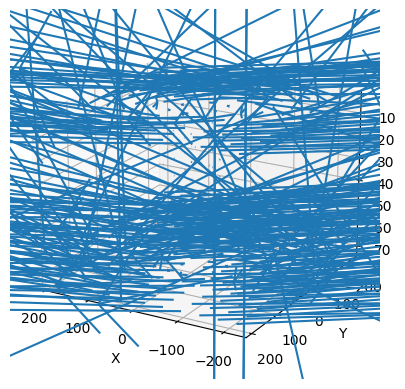

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spacing = 5
scale_factor = 10  # adjust arrow length

for key in dic:
    d = dic[key]
    XX = d['X'][::spacing, ::spacing]
    YY = d['Y'][::spacing, ::spacing]
    ZZ = d['Depth']*np.ones(XX.shape)
    UU = d['u'][::spacing, ::spacing]
    VV = d['v'][::spacing, ::spacing]
    WW = np.zeros_like(UU)

    ax.quiver(XX, YY, ZZ, UU, VV, WW, length=scale_factor)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.invert_zaxis()
ax.view_init(elev=20, azim=120)

plt.show()


In [15]:
import numpy as np
from scipy.interpolate import griddata

# 1) collect all (x,y,z) points and their u,v values
pts = []
uvals = []
vvals = []
for d in dic.values():
    X = d['X'].ravel()
    Y = d['Y'].ravel()
    Z = d['Depth'] * np.ones_like(X)
    pts.append(np.column_stack((X, Y, Z)))
    uvals.append((d['u'] * scale_factor).ravel())
    vvals.append((d['v'] * scale_factor).ravel())

pts   = np.vstack(pts)
uvals = np.concatenate(uvals)
vvals = np.concatenate(vvals)

# 2) choose your new grid resolution
nz = len(dic)
ny = max(d['X'].shape[0] for d in dic.values()) // 2
nx = max(d['X'].shape[1] for d in dic.values()) // 2

xi = np.linspace(pts[:,0].min(), pts[:,0].max(), nx)
yi = np.linspace(pts[:,1].min(), pts[:,1].max(), ny)
zi = np.linspace(pts[:,2].min(), pts[:,2].max(), nz)
# zi = -z_r[:np.sort([int(a[1:]) for a in dic.keys()]).max()+1]

Xg, Yg, Zg = np.meshgrid(xi, yi, zi, indexing='xy')
grid_pts   = np.column_stack((Xg.ravel(), Yg.ravel(), Zg.ravel()))

# 3) interpolate onto the cube
U = griddata(pts, uvals, grid_pts, method='linear', fill_value=0)
V = griddata(pts, vvals, grid_pts, method='linear', fill_value=0)
# W = np.zeros_like(U)

# 4) reshape back to 3D
U = U.reshape(Xg.shape)
V = V.reshape(Xg.shape)
# W = W.reshape(Xg.shape)


In [16]:
from scipy.sparse import diags
from utils import solve_w

W = solve_w(U, V, xi, yi, zi)


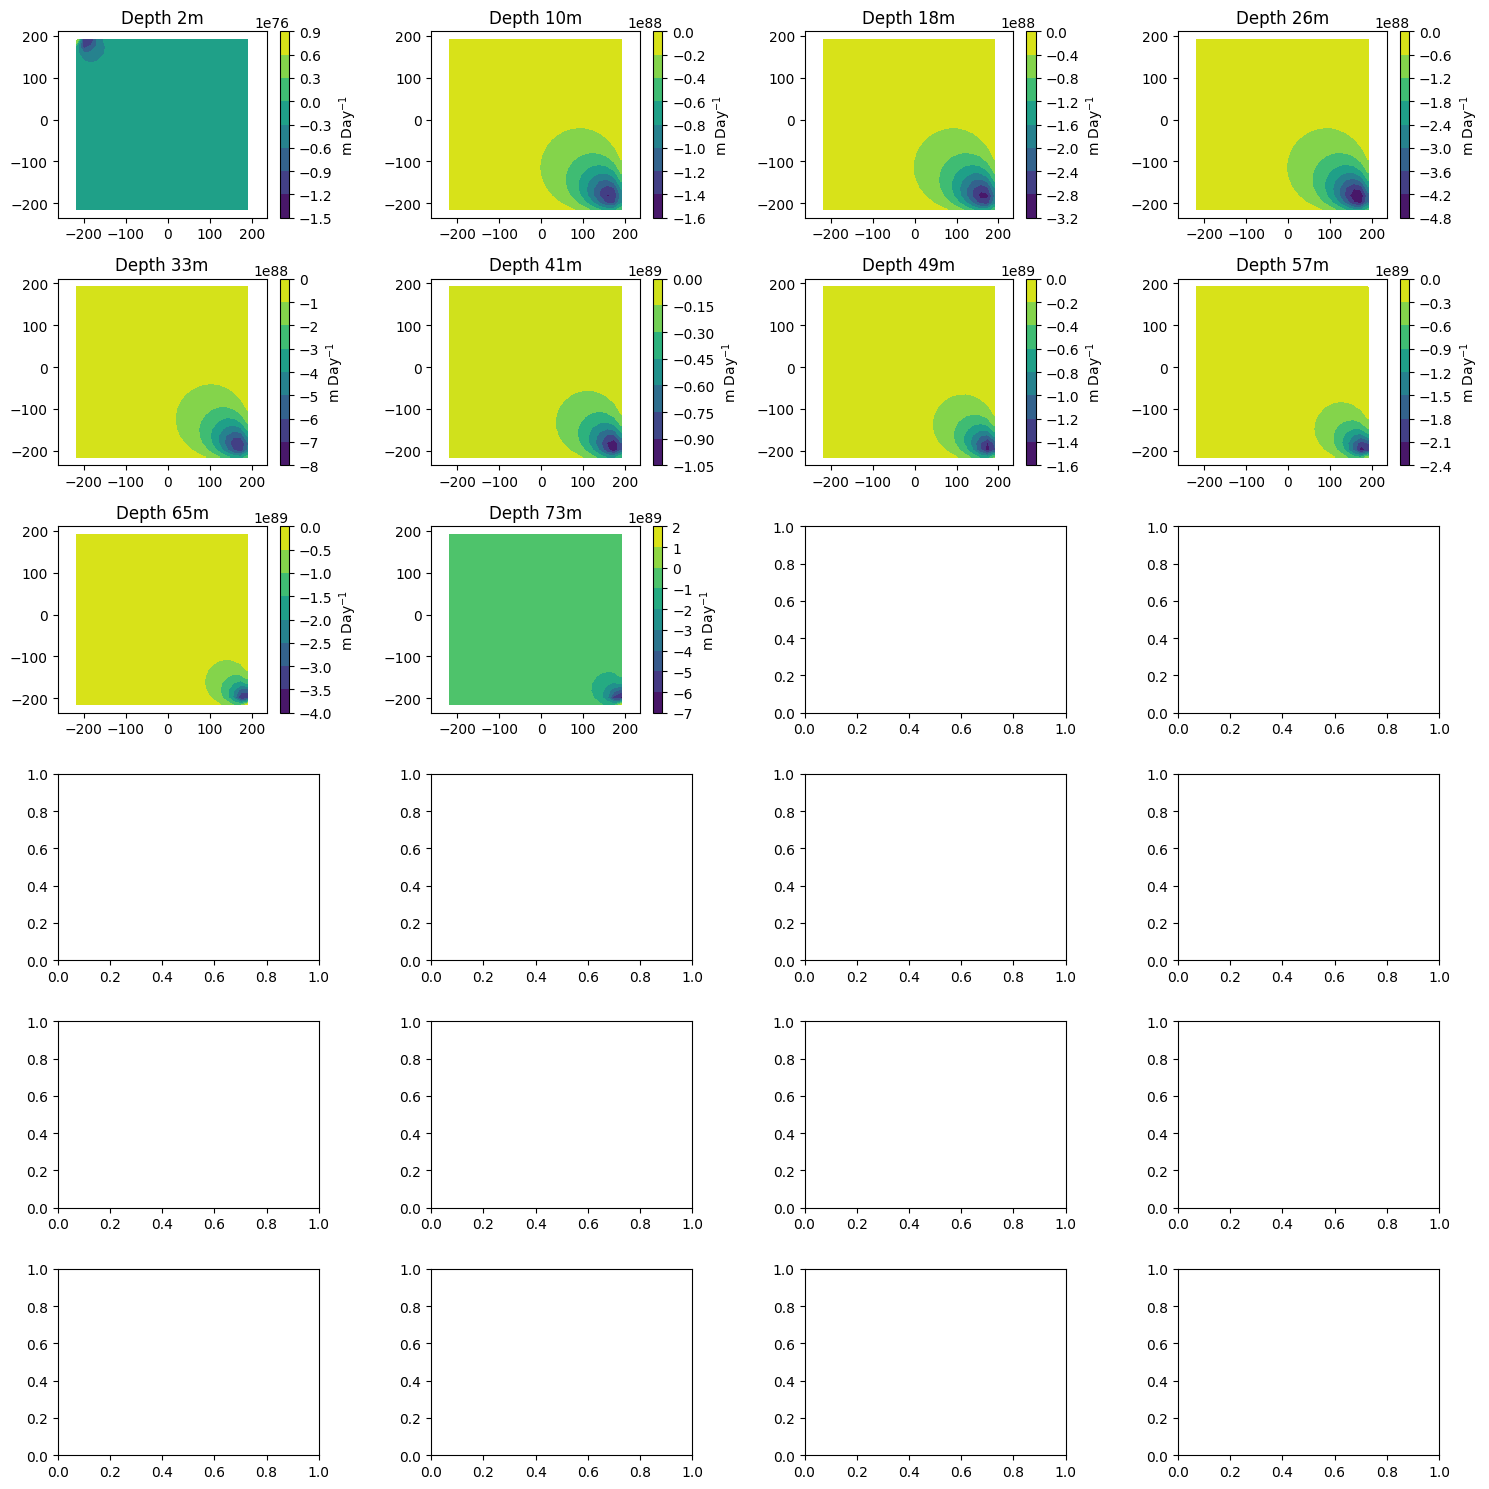

In [17]:
fig, axs = plt.subplots(6, 4, figsize=(15, 15))
for p in range(W.shape[-1]):
    ax = axs[p // 4, p % 4]
    cf = ax.contourf(xi, yi, W[:, :, p] * 86400 )
    ax.axis('equal')
    ax.set_title(f'Depth {round(zi[p])}m')
    fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
plt.tight_layout()
plt.show()


### $\sigma_{OW}$

In [18]:
def calc_ow(uu, vv, dx, dy, flag=True):
    WIDTH, LENGTH, SIGMAS = uu.shape

    if flag:
        for k in range(SIGMAS):
            uu[:,:,k] = uu[:,:,k].T
            vv[:,:,k] = vv[:,:,k].T
    
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [19]:
dx = np.diff(xi)[0]
dy = np.diff(yi)[0]

ow = calc_ow(U, V, dx*1000, dy*1000)
sigma_ow = normalize_matrix(ow)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates

# ---- assume you already have ----
# sigma_ow : 3D numpy array of your scalar field
# Xg, Yg, Zg : 3D numpy arrays (same shape as sigma_ow)
# ---------------------------------

# 1. extract isosurface in index-space
verts, faces, normals, values = marching_cubes(sigma_ow, level=-0.2)

# 2. map each index‐space vertex into your real-world coords
#    verts is (Nverts, 3), columns = (i, j, k)
#    map_coordinates expects coordinates as (dim, Npoints)
pts = verts.T  # shape (3, Nverts)

# interpolate each coordinate array at those fractional indices
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)

# stack back into (Nverts, 3)
real_verts = np.vstack((real_x, real_y, real_z)).T

# 3. plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# # optionally plot quiver of your velocity vectors (downsampled)
# step = 5
# ax.quiver(
#     Xg[::step,::step,::step],
#     Yg[::step,::step,::step],
#     Zg[::step,::step,::step],
#     U[::step,::step,::step],  # replace Ui, Vi, Wi with your vector components
#     V[::step,::step,::step],
#     W[::step,::step,::step],
#     length=10, normalize=True,  # adjust as needed
#     linewidths=0.5
# )

# 4. set axes limits to the extents of your grid
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())

# if you still want z inverted:
ax.invert_zaxis()

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

plt.tight_layout()
plt.show()


ValueError: Surface level must be within volume data range.